# Necessary Libs

In [2]:
# System libs
import os, csv, torch, scipy.io, PIL.Image, torchvision.transforms
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import urllib.request
from tqdm import tqdm

# Download the model weights
- Model can be found at http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/

In [3]:
model_weights = 'pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/'

if not os.path.exists(model_weights):
    os.makedirs(model_weights)

# Check if folder is empty
if not os.listdir(model_weights):
    print("Folder is empty, downloading weights...")
    # Define the download function
    def download_weights(url, filename):
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, model_weights + filename, reporthook=lambda blocks, block_size, total_size: t.update(block_size))

    # Download the encoder weights
    encoder_url = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth'
    encoder_filename = 'encoder_epoch_20.pth'
    download_weights(encoder_url, encoder_filename)

    # Download the decoder weights
    decoder_url = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth'
    decoder_filename = 'decoder_epoch_20.pth'
    download_weights(decoder_url, decoder_filename)

    print("Weights downloaded successfully!")
else:
    print("Folder is not empty, skipping weight download.")


Folder is not empty, skipping weight download.


# Load colors and class names for segmentation

In [4]:
colors = scipy.io.loadmat('pretrained_seg_model/data/color150.mat')['colors']
names = {}
with open('pretrained_seg_model/data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

In [5]:
names

{1: 'wall',
 2: 'building',
 3: 'sky',
 4: 'floor',
 5: 'tree',
 6: 'ceiling',
 7: 'road',
 8: 'bed',
 9: 'windowpane',
 10: 'grass',
 11: 'cabinet',
 12: 'sidewalk',
 13: 'person',
 14: 'earth',
 15: 'door',
 16: 'table',
 17: 'mountain',
 18: 'plant',
 19: 'curtain',
 20: 'chair',
 21: 'car',
 22: 'water',
 23: 'painting',
 24: 'sofa',
 25: 'shelf',
 26: 'house',
 27: 'sea',
 28: 'mirror',
 29: 'rug',
 30: 'field',
 31: 'armchair',
 32: 'seat',
 33: 'fence',
 34: 'desk',
 35: 'rock',
 36: 'wardrobe',
 37: 'lamp',
 38: 'bathtub',
 39: 'railing',
 40: 'cushion',
 41: 'base',
 42: 'box',
 43: 'column',
 44: 'signboard',
 45: 'chest',
 46: 'counter',
 47: 'sand',
 48: 'sink',
 49: 'skyscraper',
 50: 'fireplace',
 51: 'refrigerator',
 52: 'grandstand',
 53: 'path',
 54: 'stairs',
 55: 'runway',
 56: 'case',
 57: 'pool',
 58: 'pillow',
 59: 'screen',
 60: 'stairway',
 61: 'river',
 62: 'bridge',
 63: 'bookcase',
 64: 'blind',
 65: 'coffee',
 66: 'toilet',
 67: 'flower',
 68: 'book',
 69: '

# Build Encoder-Decoder model

In [6]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cpu()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

# Visualization function

In [7]:
def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)

    # aggregate images and save
    im_vis = np.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

# Load one image

In [8]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('captchas/examples/4x4/traffic lights_4.png').convert('RGB')
img_original = np.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cpu()}
output_size = img_data.shape[1:]

# Predict on that image

In [9]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
    
# Get the predicted scores for each pixel
_, prediction = torch.max(scores, dim=1)
prediction = prediction.cpu()[0].numpy()

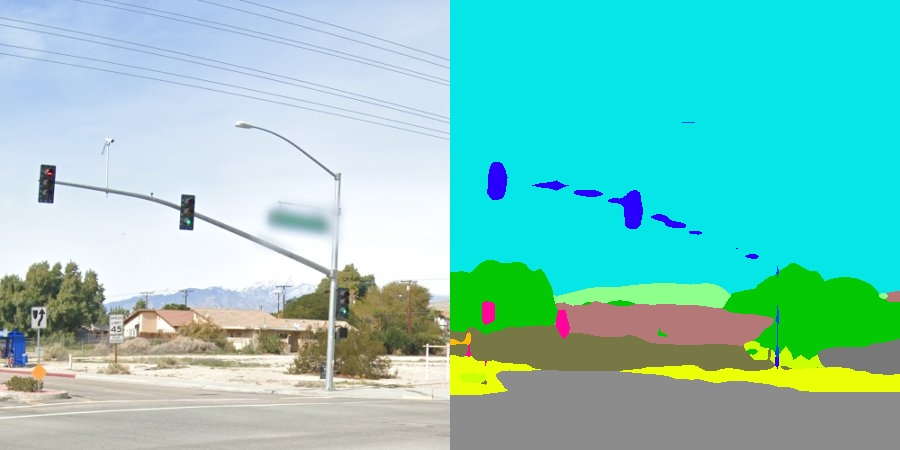

In [10]:
visualize_result(img_original, prediction)

sky:


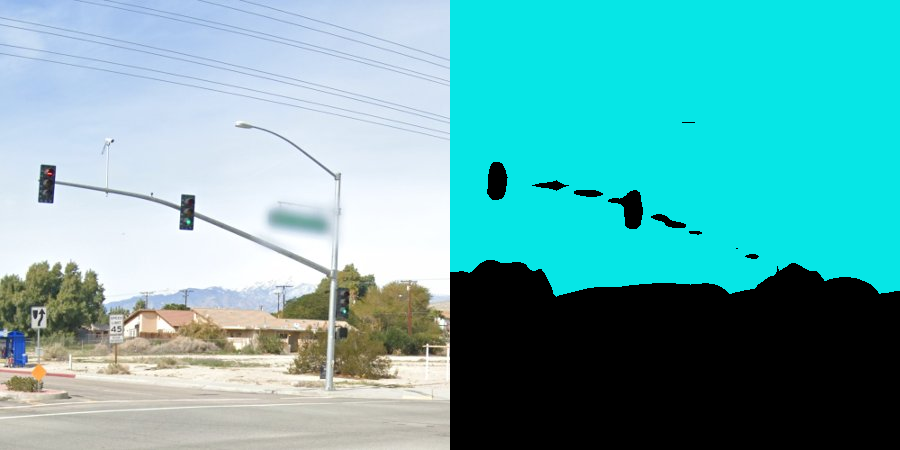

road:


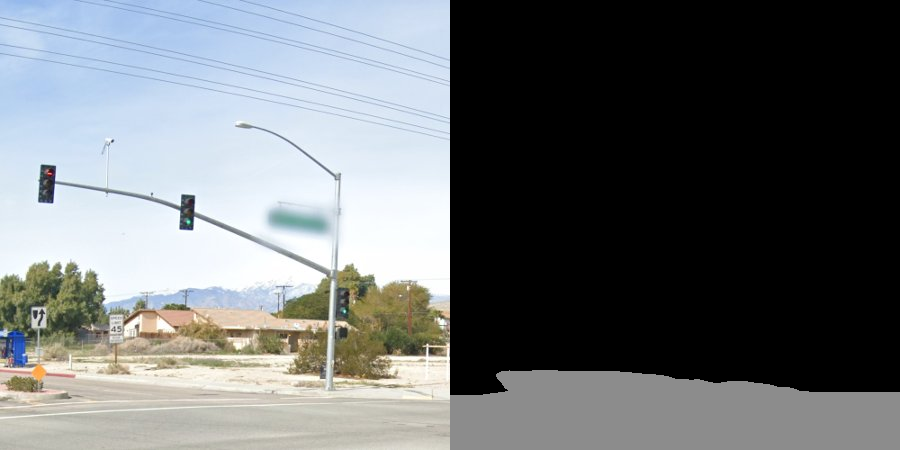

tree:


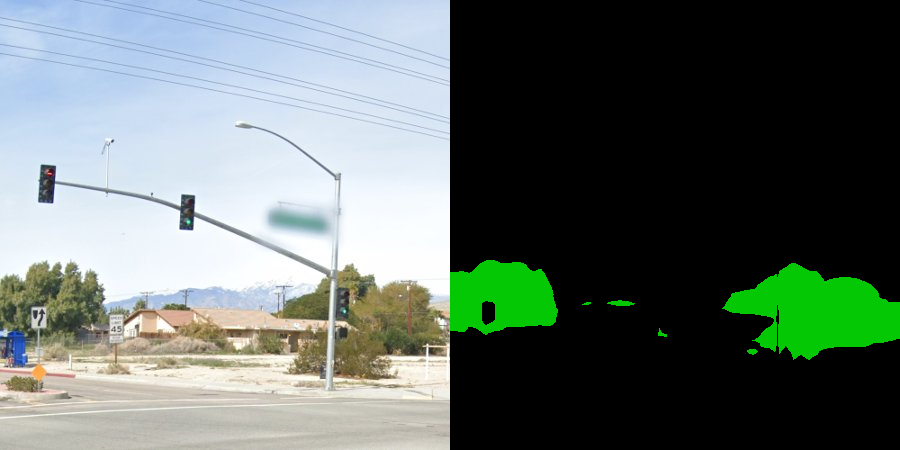

earth:


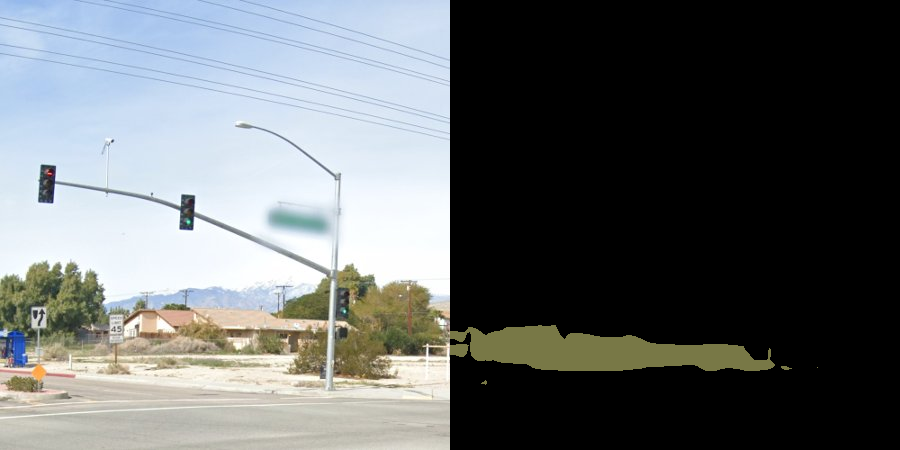

building:


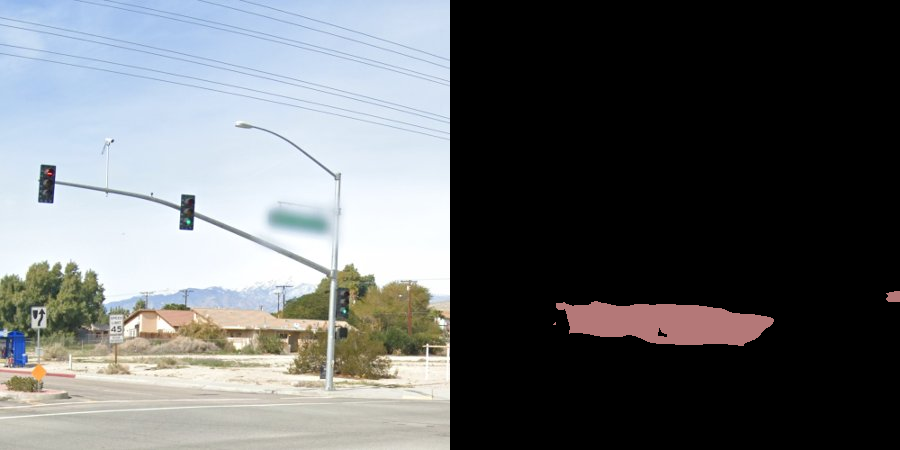

In [11]:
# Top 5 classes in answer
predicted_classes = np.bincount(prediction.flatten()).argsort()[::-1]
for c in predicted_classes[:5]:
    visualize_result(img_original, prediction, c)

# Now that we know our segmentation model works let us actually solve CAPTCHAs

# We need to solve 3 types of CAPTCHAS:

- Google Recaptchas:
  - <br> <img src="https://developers.nopecha.com/static/recaptcha.png" width="600"> <br>
  - These captchas fall into two categories:
    - 3x3 images where there are 9 images within the captcha
    - 4x4 images where one image is segmented into a 4x4 grid

- Alphanumeric captchas:
  - These are outdated but still used
  -  <br> <img src="captchas/letters/2b827.png" width="600"> <br>

# Solving 3x3 Recaptchas

## Convert a 3x3 captcha image to an array of 9 images

In [12]:
def img_to_arr(img_path, n):
    '''
        Takes the path to an image and n, the number of rows and columns in the grid
        Returns an array of n**2, h/n x w/n images
    '''
    image = Image.open(img_path).convert('RGB')
    # Convert the image to a numpy array
    image_array = np.array(image)
    h, w, c = image_array.shape
    # Split the image array into n**2 h/n x w/n sections
    sections = []
    for i in range(n):
        for j in range(n):
            section = image_array[i*h//n:(i+1)*h//n, j*w//n:(j+1)*w//n]
            sections.append(section)
    # Convert the sections list to a numpy array
    sections_array = np.array(sections)
    return sections_array

## Solve 3x3 captcha

In [13]:
def solve_3_x_3(img_path, target_name, confidence, debug=False):
    '''
        Solves a 3x3 recaptcha image.
        img_path: The path to the image to solve.
        target_name: The name of the target class. E.g. "stairs" Target class should be in the 150 classes of the MIT dataset.
        confidence: The confidence threshold. The function will append 'True' if the target class is within the top 'confidence' predictions.
        debug: If True, will visualize the predictions for each square.

        Returns 
            pred_df: A dataframe of the predictions for each square.
            output_list: A list of booleans. True if the target class is in the top 'confidence' predictions for that square. False otherwise.
    '''

    # Define the transformation to apply to each image
    pil_to_tensor = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
            std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ])

    # Define the output list to return
    output_list = []
    # Define the dictionary of predictions to return
    pred_dict = {}

    img_array = img_to_arr(img_path, 3)
    # Iterate over each image in the array
    enumerate(img_array)
    for idx, img in enumerate(img_array):
        # Convert the image to a tensor and apply the transformation
        pil_image = PIL.Image.fromarray(img)
        img_data = pil_to_tensor(pil_image)
        singleton_batch = {'img_data': img_data[None].cpu()}

        # Run the segmentation model on the image
        with torch.no_grad():
            scores = segmentation_module(singleton_batch, segSize=img_data.shape[1:])
        _, pred = torch.max(scores, dim=1)
        pred = pred.cpu()[0].numpy()

        # Visualize the predictions
        if debug:
            visualize_result(img, pred)

        # Check if the target class is present in the image
        target_class = -1
        for i in range(len(names)):
            if names[i+1] == target_name:
                target_class = i
                break
        if target_class == -1:
            raise ValueError('Target class not found in the class names.')
        
        top_preds = np.argsort(np.bincount(pred.flatten()))[::-1][:confidence]
        top_classes = [names[i+1] for i in top_preds]
        is_present = target_class in top_preds
        
        output_list.append(is_present)
        pred_dict[idx] = {f'Pred #{str(i+1)}': val for i, val in enumerate(top_classes)}
        
    pred_df = pd.DataFrame(pred_dict)
    return output_list, pred_df


## Visualize 3x3 CAPTCHA solving

### Example 1: Car

### Verify car label is in the MIT dataset

In [14]:
"car" in names.values()

True

### The dataframe below shows the top 5 predictions for each image on this captcha where we are looking for a car
<img src="captchas/examples/3x3/cars_8.png" width="500">

In [15]:
input_img = 'captchas/examples/3x3/cars_8.png'
output_list, pred_df = solve_3_x_3(img_path=input_img, target_name='car', confidence=5)
print(output_list)
pred_df

[True, False, True, True, False, True, False, False, True]


,0,1,2,3,4,5,6,7,8
Pred #1,road,building,building,car,sky,road,sky,sky,sky
Pred #2,car,road,tree,building,building,building,building,building,road
Pred #3,person,sidewalk,sky,grass,tree,car,pole,earth,building
Pred #4,building,sky,road,sky,road,sidewalk,tree,tree,tree
Pred #5,wall,person,car,floor,signboard,grass,traffic,road,car


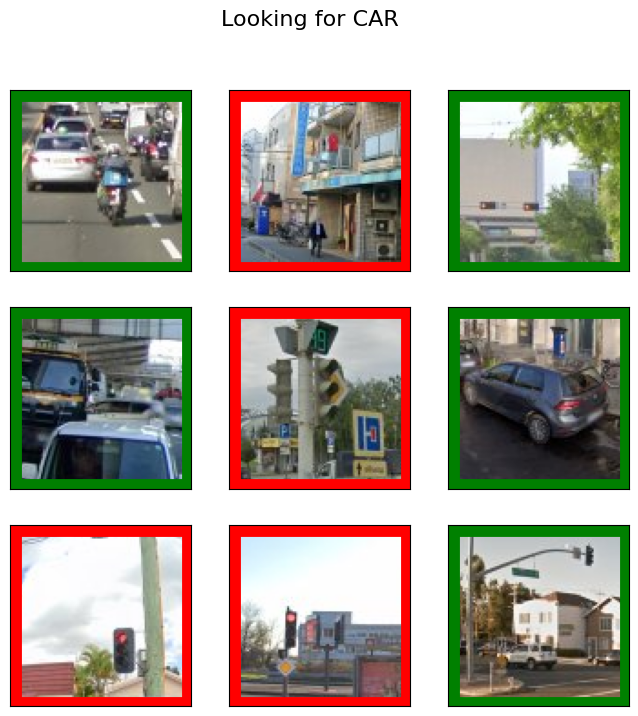

In [16]:
array_img = img_to_arr(input_img, 3)
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Looking for CAR', fontsize=16)
for i, axi in enumerate(ax.flat):
        axi.imshow(array_img[i])
        if output_list[i]:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='g', facecolor='none'))
        else:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='r', facecolor='none'))
        axi.set(xticks=[], yticks=[])
plt.show()

### Another example on a 3x3 captcha

In [17]:
input_img = 'captchas/examples/3x3/cars_8.png'
output_list, pred_df = solve_3_x_3(img_path=input_img, target_name='car', confidence=5)
print(output_list)
pred_df

[True, False, True, True, False, True, False, False, True]


,0,1,2,3,4,5,6,7,8
Pred #1,road,building,building,car,sky,road,sky,sky,sky
Pred #2,car,road,tree,building,building,building,building,building,road
Pred #3,person,sidewalk,sky,grass,tree,car,pole,earth,building
Pred #4,building,sky,road,sky,road,sidewalk,tree,tree,tree
Pred #5,wall,person,car,floor,signboard,grass,traffic,road,car


### Example 2: Hills

In [18]:
"hill" in names.values()

True

### The dataframe below shows the top 5 predictions for each image on this captcha where we are looking for hills
<img src="captchas/examples/3x3/mountains or hills_7.png" width="500">

In [19]:
input_img = 'captchas/examples/3x3/mountains or hills_7.png'
output_list, pred_df = solve_3_x_3(img_path=input_img, target_name='hill', confidence=10)
print(output_list)
pred_df

[False, False, False, False, False, False, False, False, False]


,0,1,2,3,4,5,6,7,8
Pred #1,building,building,tree,tree,wall,building,tree,building,tree
Pred #2,road,sidewalk,bridge,mountain,floor,sidewalk,signboard,road,sky
Pred #3,tree,person,sky,road,fan,tree,mountain,sidewalk,building
Pred #4,sidewalk,road,mountain,building,bicycle,road,wall,car,road
Pred #5,pot,cabinet,grass,sky,refrigerator,person,earth,pole,mountain
Pred #6,plant,grass,fence,door,skyscraper,cabinet,sky,person,bed
Pred #7,car,windowpane,river,bed,sink,grass,cushion,box,floor
Pred #8,sky,bed,earth,floor,sand,windowpane,cabinet,column,ceiling
Pred #9,column,ceiling,road,ceiling,counter,bed,plant,mirror,windowpane
Pred #10,sand,tree,chair,windowpane,chest,ceiling,base,rug,table


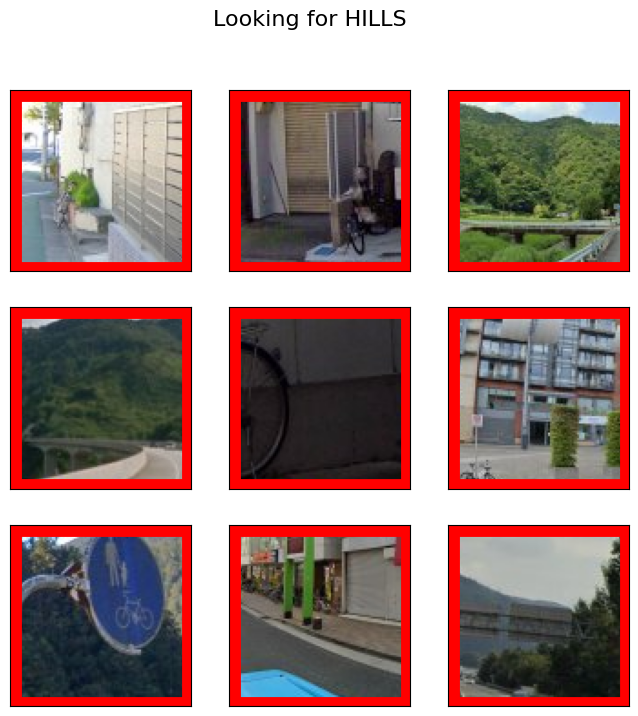

In [20]:
array_img = img_to_arr(input_img, 3)
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Looking for HILLS', fontsize=16)
for i, axi in enumerate(ax.flat):
        axi.imshow(array_img[i])
        if output_list[i]:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='g', facecolor='none'))
        else:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='r', facecolor='none'))
        axi.set(xticks=[], yticks=[])
plt.show()

### Example 2.5: Mountains

In [21]:
"mountain" in names.values()

True

In [22]:
input_img = 'captchas/examples/3x3/mountains or hills_7.png'
output_list, pred_df = solve_3_x_3(img_path=input_img, target_name='mountain', confidence=5)
print(output_list)
pred_df

[False, False, True, True, False, False, True, False, True]


,0,1,2,3,4,5,6,7,8
Pred #1,building,building,tree,tree,wall,building,tree,building,tree
Pred #2,road,sidewalk,bridge,mountain,floor,sidewalk,signboard,road,sky
Pred #3,tree,person,sky,road,fan,tree,mountain,sidewalk,building
Pred #4,sidewalk,road,mountain,building,bicycle,road,wall,car,road
Pred #5,pot,cabinet,grass,sky,refrigerator,person,earth,pole,mountain


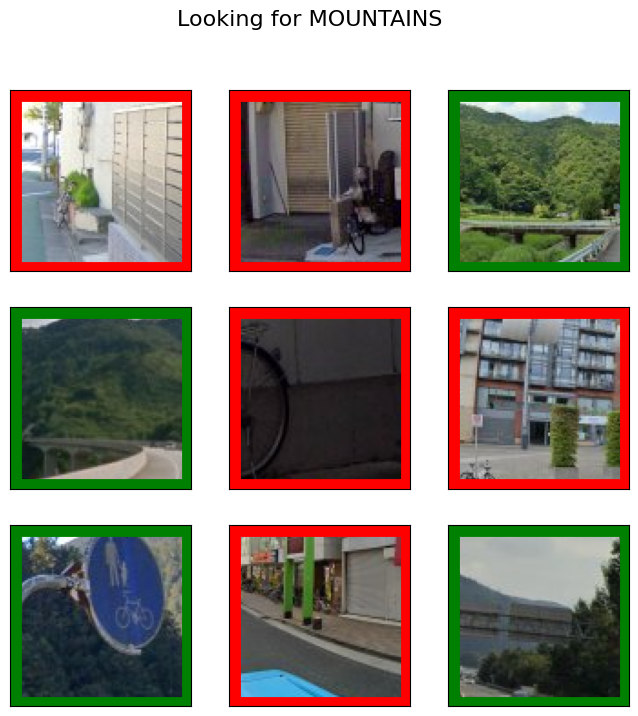

In [23]:
array_img = img_to_arr(input_img, 3)
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Looking for MOUNTAINS', fontsize=16)
for i, axi in enumerate(ax.flat):
        axi.imshow(array_img[i])
        if output_list[i]:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='g', facecolor='none'))
        else:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='r', facecolor='none'))
        axi.set(xticks=[], yticks=[])
plt.show()

# Solving 4x4 Captchas

## Convert an array of nxn predictions into a 4x4 grid
- This will be used for finding the dominant prediction in each square of the grid

In [24]:
def create_grid_pred(arr, n):
    '''
        Takes an array of predictions and n, the number of rows and columns in the grid
        Returns an n x n grid of predictions
    '''
    h, w = arr.shape[:2]
    grid_h, grid_w = n, n
    sub_h, sub_w = h // grid_h, w // grid_w
    grid = np.zeros((grid_h, grid_w, sub_h, sub_w) + arr.shape[2:], dtype=arr.dtype)
    for i in range(grid_h):
        for j in range(grid_w):
            sub_arr = arr[i*sub_h:(i+1)*sub_h, j*sub_w:(j+1)*sub_w]
            grid[i, j] = sub_arr
    return grid

In [25]:
prediction.shape

(450, 450)

In [26]:
create_grid_pred(prediction, 4).shape

(4, 4, 112, 112)

In [27]:
def solve_4x4(img_path, target_name, confidence):
    '''
        Solves a 4x4 recaptcha image.
        img_path: The path to the image to solve.
        target_name: The name of the target class. E.g. "stairs" Target class should be in the 150 classes of the MIT dataset.
        confidence: The confidence threshold. The function will append 'True' if the target class is within the top 'confidence' predictions.
        debug: If True, will visualize the predictions for each square.

        Returns 
            pred_df: A dataframe of the predictions for each square.
            output_list: A list of booleans. True if the target class is in the top 'confidence' predictions for that square. False otherwise.
    '''

    # Define the transformation to apply to the image
    pil_to_tensor = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
            std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ])

    # Define the output list to return
    output_list = []
    # Define the dictionary of predictions to return
    pred_dict = {}

    # Load the image
    pil_image = PIL.Image.open(img_path).convert('RGB')
    # Convert the image to a numpy array
    img_original = np.array(pil_image)
    # Convert the image to a tensor
    img_data = pil_to_tensor(pil_image)
    # Create a singleton batch
    singleton_batch = {'img_data': img_data[None].cpu()}
    # Get the output size
    output_size = img_data.shape[1:]

    # Run the segmentation at the highest resolution.
    with torch.no_grad():
        scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()

    # Create a grid of predictions
    pred_grid = create_grid_pred(pred, 4)

    for r in range(4):
        for c in range(4):
            # Get the prediction for the current square
            pred = pred_grid[r][c]
            # Check if the target class is present in the image
            target_class = -1
            for i in range(len(names)):
                if names[i+1] == target_name:
                    target_class = i
                    break
            if target_class == -1:
                raise ValueError('Target class not found in the class names.')
            
            top_preds = np.argsort(np.bincount(pred.flatten()))[::-1][:confidence]
            top_classes = [names[i+1] for i in top_preds]
            is_present = target_class in top_preds
            
            output_list.append(is_present)
            pred_dict[f'{r},{c}'] = top_classes

    # Get maximum length of arrays in pred_dict
    max_len = max(len(v) for v in pred_dict.values())
    # Pad shorter arrays with NaN values
    d_padded = {k: v + [np.nan]*(max_len - len(v)) for k, v in pred_dict.items()}
    # Convert to dataframe
    pred_df = pd.DataFrame.from_dict(d_padded)
    return output_list, pred_df


## Visualize 4x4 CAPTCHA solving
### Example 1: Bicycle
### Verify bicycle label is in the MIT dataset

In [28]:
"bicycle" in names.values()

True

### The dataframe below shows the top 5 predictions for each image on this captcha where we are looking for a bicycle
<img src="captchas/examples/4x4/bicycles_4.png" width="500">

In [29]:
input_img = 'captchas/examples/4x4/bicycles_4.png'
output_list, pred_df = solve_4x4(input_img, "bicycle", confidence=10)
print(output_list)
pred_df

[False, False, False, False, True, True, True, False, False, True, True, False, False, False, False, False]


,"0,0","0,1","0,2","0,3","1,0","1,1","1,2","1,3","2,0","2,1","2,2","2,3","3,0","3,1","3,2","3,3"
0,car,car,tree,tree,car,person,grass,tree,grass,grass,bicycle,tree,path,earth,earth,path
1,plant,grass,grass,floor,tree,car,person,grass,person,bicycle,grass,grass,grass,grass,path,sidewalk
2,wall,rock,earth,sky,person,grass,bicycle,windowpane,car,person,earth,windowpane,road,path,floor,boat
3,tree,tree,pole,building,grass,bicycle,tree,bed,tree,earth,tree,bed,earth,road,grass,tree
4,building,earth,mountain,wall,bicycle,column,road,road,building,fence,sand,road,sofa,water,water,car
5,grass,road,rock,NaN,counter,counter,car,ceiling,sky,screen,counter,ceiling,painting,sofa,tree,floor
6,curtain,door,road,NaN,chest,chest,column,floor,floor,sand,chest,floor,water,painting,wall,table
7,bed,person,car,NaN,signboard,signboard,sand,sky,ceiling,rock,signboard,sky,car,car,counter,earth
8,sky,sidewalk,plant,NaN,column,box,counter,building,road,wardrobe,column,building,chair,chair,sidewalk,water
9,floor,cabinet,rug,NaN,box,sink,chest,wall,bed,lamp,box,wall,curtain,curtain,car,armchair


/var/folders/3x/vqcykbm5477c2ks1kh1yzcbr0000gn/T/ipykernel_4673/3180695521.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sections_array = np.array(sections)


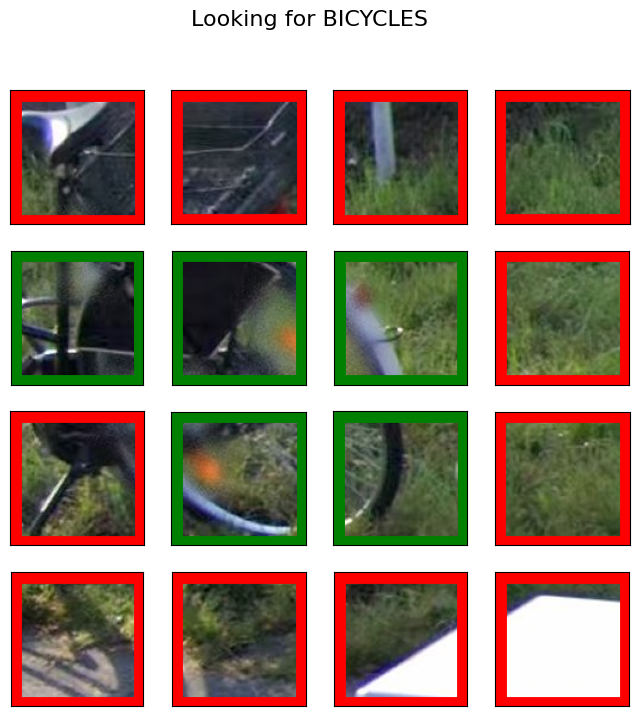

In [30]:
array_img = img_to_arr(input_img, 4)
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
        axi.imshow(array_img[i])
        if output_list[i]:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='g', facecolor='none'))
        else:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='r', facecolor='none'))
        axi.set(xticks=[], yticks=[])
plt.suptitle('Looking for BICYCLES', fontsize=16)
plt.show()

# Conclusions

- Many classes in CAPTCHAs exist in the MIT dataset
- Sometimes variations of the classes exist, and one variation is predicted more strongly than the other
  - Example: hill vs mountain
- To move forward with this we will need to be able to translate Google's captcha prompts into a class our model can work with
- Our classname csv file also has many synonymous classnames we are currently not using
- We may also need to add onto this model so it specialized on reCaptcha tasks